In [ ]:
#importing require python packages
import pandas as pd
from keras.models import Model, load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from keras.layers import  MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D
from keras.models import Sequential
from keras.models import model_from_json
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2D, MaxPool2D,InputLayer, BatchNormalization

2024-09-04 17:31:39.911429: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-04 17:31:39.911567: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-04 17:31:40.057544: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
import os
import cv2
import numpy as np

#function to return integer id of the disease name

labels = ['Cerscospora', 'Healthy', 'Leaf rust', 'Miner', 'Phoma']
def getID(name):
    index = 0
    for i in range(len(labels)):
        if labels[i] == name:
            index = i
            break
    return index

# Function to load and process images
def load_and_process_images(path):
    X, Y = [], []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')) and 'Thumbs.db' not in file:
                img_path = os.path.join(root, file)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (100,100))
                    X.append(img)
                    label = getID(os.path.basename(root))
                    Y.append(label)
    return np.array(X), np.array(Y)
dataset_path = "/kaggle/input/datasetnammer/Dataset"
X, Y = load_and_process_images(dataset_path)


print("Coffee Leaf Disease Dataset Loading Completed")
print(f"Total Processed Images are: {X.shape[0]}")

Premature end of JPEG file


Coffee Leaf Disease Dataset Loading Completed
Total Processed Images are: 58549


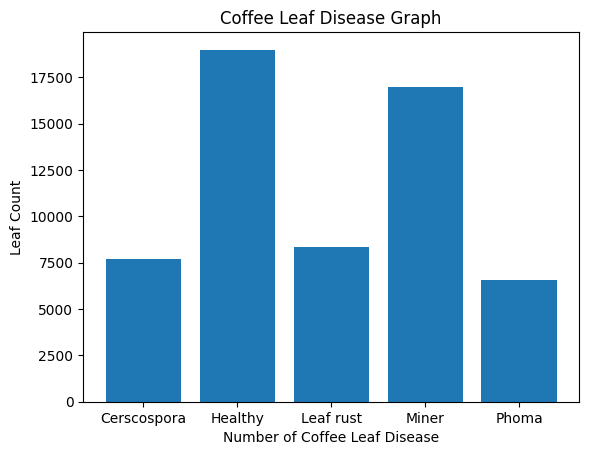

In [ ]:
unique, count = np.unique(Y, return_counts=True)
height = count
bars = labels
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.ylabel("Leaf Count")
plt.xlabel("Number of Coffee Leaf Disease")
plt.title("Coffee Leaf Disease Graph")
plt.show()

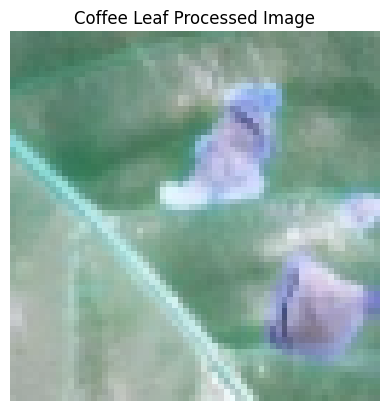

In [ ]:
# #shuffling and normalizing the dataset
# X = X.astype('float32')
# X = X/255
# indices = np.arange(X.shape[0])
# np.random.shuffle(indices) #dataset shuffling
# X = X[indices]
# Y = Y[indices]
# Y = to_categorical(Y)

# #now plot sample processed messidor image
processed_image = X[3]
processed_image = cv2.resize(processed_image, (64, 64))
plt.imshow(processed_image)
plt.title('Coffee Leaf Processed Image')
plt.axis('off')
plt.show()

In [ ]:
print(X.shape)
print(Y.shape)

(58549, 100, 100, 3)
(58549,)


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

def reduce_class_size(images, labels, min_count):
    balanced_images = []
    balanced_labels = []

    counter = Counter(labels)

    for class_label in counter:
        class_images = [img for img, lbl in zip(images, labels) if lbl == class_label]
        class_images = class_images[:min_count]  # Limit to min_count images
        balanced_images.extend(class_images)
        balanced_labels.extend([class_label] * len(class_images))

    return np.array(balanced_images), np.array(balanced_labels)

def preprocess_data(images, labels):
    # Normalize images
    X = np.array(images, dtype=np.float32) / 255.0

    # Convert labels to one-hot encoding
    lb = LabelBinarizer()
    y = lb.fit_transform(labels)

    return X, y, lb.classes_

images = X
labels = Y

# Class distribution before balancing
counter_before = Counter(labels)
print("Class distribution before balancing:", counter_before)

# Balance the classes by reducing to min value
min_count = 6571
balanced_images, balanced_labels = reduce_class_size(images, labels, min_count)

# Class distribution after balancing
counter_after = Counter(balanced_labels)
print("Class distribution after balancing:", counter_after)

# Preprocess the data
X, y, classes = preprocess_data(balanced_images, balanced_labels)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Classes:", classes)
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)


Class distribution before balancing: Counter({1: 18983, 3: 16978, 2: 8336, 0: 7681, 4: 6571})
Class distribution after balancing: Counter({3: 6571, 2: 6571, 0: 6571, 4: 6571, 1: 6571})
Classes: [0 1 2 3 4]
Training data shape: (26284, 100, 100, 3)
Testing data shape: (6571, 100, 100, 3)


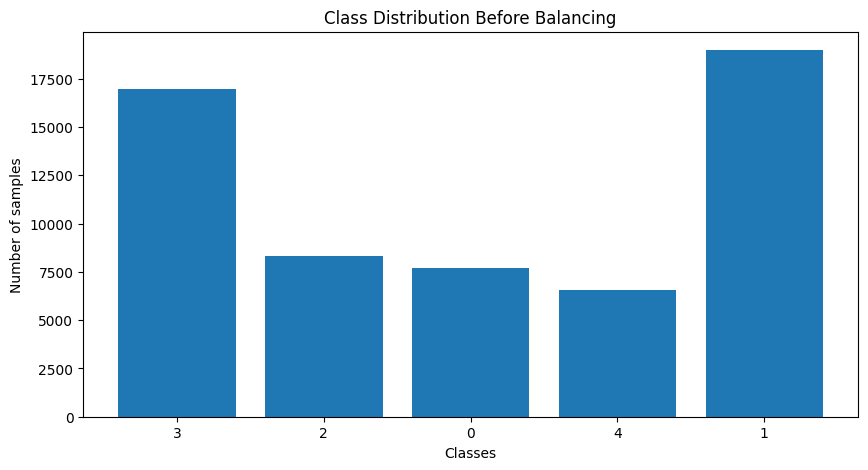

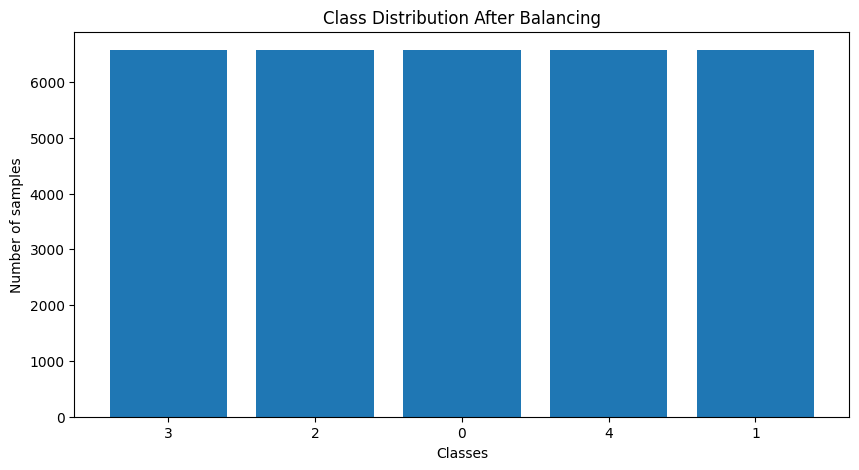

In [ ]:
def plot_class_distribution(counter, title):
    labels, values = zip(*counter.items())
    labels = [str(lbl) for lbl in labels]
    plt.figure(figsize=(10, 5))
    plt.bar(labels, values)
    plt.title(title)
    plt.xlabel('Classes')
    plt.ylabel('Number of samples')
    plt.show()

plot_class_distribution(counter_before, "Class Distribution Before Balancing")
plot_class_distribution(counter_after, "Class Distribution After Balancing")




In [ ]:

from imgaug import augmenters as iaa
# Step 2: Apply augmentation
augmented_images = []
augmented_labels = []

augmentation_seq = iaa.Sequential([
    iaa.Fliplr(0.5),  # horizontal flips
    iaa.Flipud(0.2),  # vertical flips
    iaa.Affine(rotate=(-20, 20)),  # random rotations
    iaa.Multiply((0.8, 1.2)),  # change brightness
    iaa.GaussianBlur(sigma=(0, 1.0))  # add Gaussian blur
])


for img, lbl in zip(balanced_images, balanced_labels):
    for _ in range(3):  # apply augmentation 3 times for each image
        augmented_image = augmentation_seq(image=img)
        augmented_images.append(augmented_image)
        augmented_labels.append(lbl)


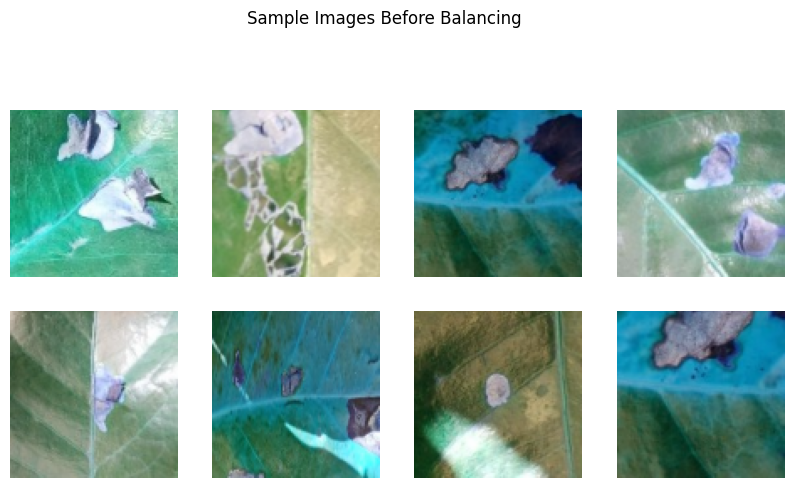

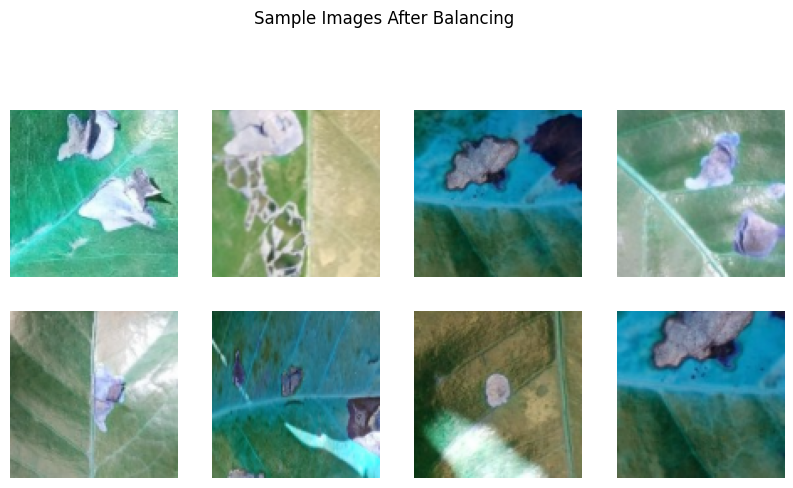

In [ ]:
# Plot some sample images
def plot_sample_images(images, title):
    plt.figure(figsize=(10, 10))
    for i in range(8):
        plt.subplot(4, 4, i+1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

plot_sample_images(images, "Sample Images Before Balancing")
plot_sample_images(balanced_images, "Sample Images After Balancing")

In [ ]:
def get_pixel(img, center, x, y):
    new_value = 0
    try:
        if img[x][y] >= center:
            new_value = 1
    except:
        pass
    return new_value


def lbp_calculated_pixel(img, x, y):
    center = img[x][y]
    val_ar = []

    val_ar.append(get_pixel(img, center, x-1, y+1))     # top_right
    val_ar.append(get_pixel(img, center, x, y+1))       # right
    val_ar.append(get_pixel(img, center, x+1, y+1))     # bottom_right
    val_ar.append(get_pixel(img, center, x+1, y))       # bottom
    val_ar.append(get_pixel(img, center, x+1, y-1))     # bottom_left
    val_ar.append(get_pixel(img, center, x, y-1))       # left
    val_ar.append(get_pixel(img, center, x-1, y-1))     # top_left
    val_ar.append(get_pixel(img, center, x-1, y))       # top

    power_val = [1, 2, 4, 8, 16, 32, 64, 128]
    val = 0
    for i in range(len(val_ar)):
        val += val_ar[i] * power_val[i]
    return val

In [ ]:
def show_output(output_list):
    output_list_len = len(output_list)
    figure = plt.figure()
    for i in range(output_list_len):
        current_dict = output_list[i]
        current_img = current_dict["img"]
        current_xlabel = current_dict["xlabel"]
        current_ylabel = current_dict["ylabel"]
        current_xtick = current_dict["xtick"]
        current_ytick = current_dict["ytick"]
        current_title = current_dict["title"]
        current_type = current_dict["type"]
        current_plot = figure.add_subplot(1, output_list_len, i+1)
        if current_type == "gray":
            current_plot.imshow(current_img, cmap = plt.get_cmap('gray'))
            current_plot.set_title(current_title)
            current_plot.set_xticks(current_xtick)
            current_plot.set_yticks(current_ytick)
            current_plot.set_xlabel(current_xlabel)
            current_plot.set_ylabel(current_ylabel)
        elif current_type == "histogram":
            current_plot.plot(current_img, color = "black")
            current_plot.set_xlim([0,260])
            current_plot.set_title(current_title)
            current_plot.set_xlabel(current_xlabel)
            current_plot.set_ylabel(current_ylabel)
            ytick_list = [int(i) for i in current_plot.get_yticks()]
            current_plot.set_yticklabels(ytick_list,rotation = 90)

    plt.show()

(100, 100, 3)


/tmp/ipykernel_34/3833388547.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  current_plot.set_yticklabels(ytick_list,rotation = 90)


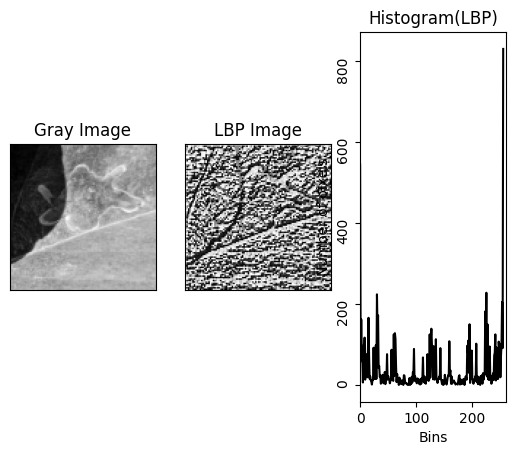

LBP Program is finished


In [ ]:

import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
import seaborn as sns
import tensorflow
image_file = images[20]
img_bgr = images[20]
height, width, channel = img_bgr.shape
print(img_bgr.shape)
img_bgr_uint8 = cv2.convertScaleAbs(img_bgr)
img_gray = cv2.cvtColor(img_bgr_uint8, cv2.COLOR_BGR2GRAY)
#img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)



img_lbp = np.zeros((height, width,3), np.uint8)
for i in range(0, height):
    for j in range(0, width):
        img_lbp[i, j] = lbp_calculated_pixel(img_gray, i, j)
hist_lbp = cv2.calcHist([img_lbp], [0], None, [256], [0, 256])
output_list = []
output_list.append({
        "img": img_gray,
        "xlabel": "",
        "ylabel": "",
        "xtick": [],
        "ytick": [],
        "title": "Gray Image",
        "type": "gray"
    })
output_list.append({
        "img": img_lbp,
        "xlabel": "",
        "ylabel": "",
        "xtick": [],
        "ytick": [],
        "title": "LBP Image",
        "type": "gray"
    })
output_list.append({
        "img": hist_lbp,
        "xlabel": "Bins",
        "ylabel": "Number of pixels",
        "xtick": None,
        "ytick": None,
        "title": "Histogram(LBP)",
        "type": "histogram"
})
show_output(output_list)


print("LBP Program is finished")

(100, 100, 3)


/tmp/ipykernel_34/3833388547.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  current_plot.set_yticklabels(ytick_list,rotation = 90)


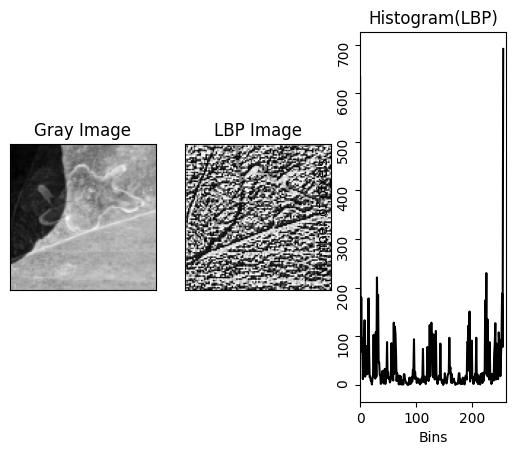

LBP Program is finished


In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
import seaborn as sns
import tensorflow
image_file = X[20]
img_bgr = X[20]
height, width, channel = img_bgr.shape
print(img_bgr.shape)
img_bgr_uint8 = cv2.convertScaleAbs(img_bgr)
img_gray = cv2.cvtColor(img_bgr_uint8, cv2.COLOR_BGR2GRAY)
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

img_lbp = np.zeros((height, width,3), np.uint8)
for i in range(0, height):
    for j in range(0, width):
        img_lbp[i, j] = lbp_calculated_pixel(img_gray, i, j)
hist_lbp = cv2.calcHist([img_lbp], [0], None, [256], [0, 256])
output_list = []
output_list.append({
        "img": img_gray,
        "xlabel": "",
        "ylabel": "",
        "xtick": [],
        "ytick": [],
        "title": "Gray Image",
        "type": "gray"
    })
output_list.append({
        "img": img_lbp,
        "xlabel": "",
        "ylabel": "",
        "xtick": [],
        "ytick": [],
        "title": "LBP Image",
        "type": "gray"
    })
output_list.append({
        "img": hist_lbp,
        "xlabel": "Bins",
        "ylabel": "Number of pixels",
        "xtick": None,
        "ytick": None,
        "title": "Histogram(LBP)",
        "type": "histogram"
})
show_output(output_list)


print("LBP Program is finished")

In [ ]:
lbp=[]
count =1
for f in range (15):
    img_bgr=images[f]
    height, width, channel = img_bgr.shape
    img_bgr_uint8 = cv2.convertScaleAbs(img_bgr)
    img_gray = cv2.cvtColor(img_bgr_uint8, cv2.COLOR_BGR2GRAY)
    img_gray = np.float32(img_gray) / 255.0
    img_lbp = np.zeros((height, width,3), np.uint8)
    for i in range(0, height):
        for j in range(0, width):
            img_lbp[i, j] = lbp_calculated_pixel(img_gray, i, j)
    lbp.append(img_lbp)

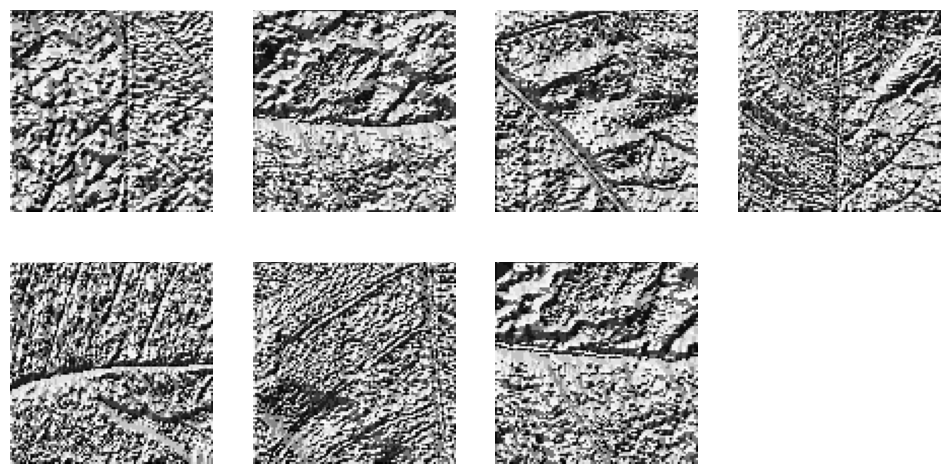

In [ ]:

fig = plt.figure(figsize=(12, 6))
for x in range(1,8):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
   # plt.title(train_labels[c])
    plt.imshow(lbp[x])

plt.rcParams.update({'font.size': 12})
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import data, color, exposure
def XCSLBP(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    imgXCSLBP = np.zeros_like(gray_image)
    neighboor = 4

    for ih in range(0,image.shape[0] - neighboor): # loop by line
        for iw in range(0,image.shape[1] - neighboor):
            ### Get natrix image 3 by 3 pixel
            img = gray_image[ih:ih+neighboor,iw:iw+neighboor]
            g0, g1, g2, g3= img[1,2], img[2,2], img[2,1], img[2,0]
            g4, g5, g6, g7 = img[1,0], img[0,0], img[0,1], img[0,2]
            neighbor = np.array([g0, g1, g2, g3], dtype="float32")
            opp_neighbor= np.array([g4, g5, g6, g7], dtype="float32")
            center = img[1,1]
            x_1 = ((neighbor - opp_neighbor) + center)
            x_2 = ((neighbor - center)*(opp_neighbor - center))
            xcslbp = ((x_1 + x_2) >= 0)*1.0
            ### Convert the binary operated values to a decimal (digit)
            where_xcslbp_vector = np.where(xcslbp)[0]
            num = np.sum(2**where_xcslbp_vector) if len(where_xcslbp_vector) >= 1 else 0
            imgXCSLBP[ih+1,iw+1] = num
    imgXCSLBP=np.array(imgXCSLBP)
    return imgXCSLBP
f=[]
for i in range (15):
    mag=XCSLBP(images[i])
    f.append(mag)


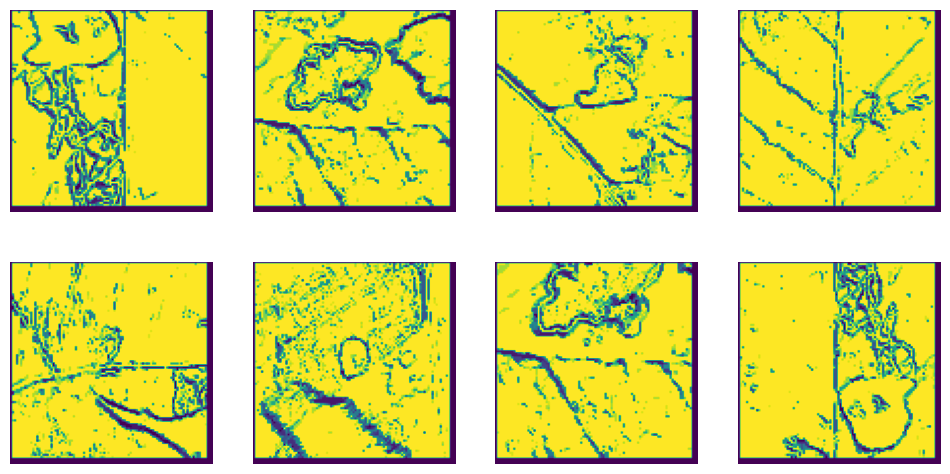

In [ ]:

fig = plt.figure(figsize=(12, 6))
for x in range(1,9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
   # plt.title(train_labels[c])
    plt.imshow(f[x])

plt.rcParams.update({'font.size': 12})
plt.show()

In [ ]:
#defining global features to store accuracy and other values
accuracy = []
precision = []
recall = []
fscore = []
losstime=[]
prdctiontime=[]

In [ ]:
#function to calculate all metrics
def calculateMetrics(algorithm, testY, predict):
    p = precision_score(testY, predict,average='macro') * 100
    r = recall_score(testY, predict,average='macro') * 100
    f = f1_score(testY, predict,average='macro') * 100
    a = accuracy_score(testY,predict)*100
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    print(algorithm+" Accuracy  : "+str(a))
    print(algorithm+" Precision : "+str(p))
    print(algorithm+" Recall    : "+str(r))
    print(algorithm+" FSCORE    : "+str(f))


In [ ]:
#defining CNN model with different layers and different number of neurons for data filtration
import time
model1 = Sequential()
#defining CNN layer with 32 filters of 3 X 3 dimension
model1.add(Convolution2D(32, (3, 3), input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation = 'relu'))
#maxpooling layeer to collect filtered optimized features from previous CNN layer and convert 3 X 3 dimension to 2 X 2
model1.add(MaxPooling2D(pool_size = (2, 2)))
#defining another CNN layer
model1.add(Convolution2D(32, (3, 3), activation = 'relu'))
#another maxpooling layer to collect optimzied features
model1.add(MaxPooling2D(pool_size = (2, 2)))
model1.add(tf.keras.layers.Dropout(0.5))
#flatten layer to convert 2 dimension features to 1 dimension
model1.add(Flatten())
#defining output layer with neuron size as 256
model1.add(Dense(units = 256, activation = 'relu'))

model1.add(tf.keras.layers.Dropout(
    0.7
))
#defining y_train target prediction layer
model1.add(Dense(units = y_train.shape[1], activation = 'softmax'))
#compile the model

model1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
#train and load the model
# if os.path.exists("model/model_weights.hdf5") == False:
#     model_check_point = ModelCheckpoint(filepath='model/model_weights.hdf5', verbose = 1, save_best_only = True)
timestart=time.time()
hist = model1.fit(X_train, y_train, batch_size = 32, epochs = 5, validation_data=(X_test, y_test),verbose=1)
#     f = open('model/history.pckl', 'wb')
#     pickle.dump(hist.history, f)
#     f.close()
# else:
#     model1.load_weights("model/model_weights.hdf5")
timeend =time.time()
losstime.append(timeend-timestart)
print("time compuitation train data " ,timeend-timestart)
print()
print("build model convolutional neural network one")
print(model1.summary())

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
822/822 ━━━━━━━━━━━━━━━━━━━━ 179s 215ms/step - accuracy: 0.7036 - loss: 0.7370 - val_accuracy: 0.9588 - val_loss: 0.1230
Epoch 2/5
822/822 ━━━━━━━━━━━━━━━━━━━━ 173s 211ms/step - accuracy: 0.9427 - loss: 0.1720 - val_accuracy: 0.9750 - val_loss: 0.0936
Epoch 3/5
822/822 ━━━━━━━━━━━━━━━━━━━━ 202s 211ms/step - accuracy: 0.9614 - loss: 0.1161 - val_accuracy: 0.9918 - val_loss: 0.0262
Epoch 4/5
822/822 ━━━━━━━━━━━━━━━━━━━━ 173s 210ms/step - accuracy: 0.9764 - loss: 0.0699 - val_accuracy: 0.9959 - val_loss: 0.0126
Epoch 5/5
822/822 ━━━━━━━━━━━━━━━━━━━━ 203s 212ms/step - accuracy: 0.9797 - loss: 0.0638 - val_accuracy: 0.9970 - val_loss: 0.0109
time compuitation train data  937.6544358730316

build model convolutional neural network one


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16928)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,333,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,035,761 (49.73 MB)

 Trainable params: 4,345,253 (16.58 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,690,508 (33.15 MB)

None


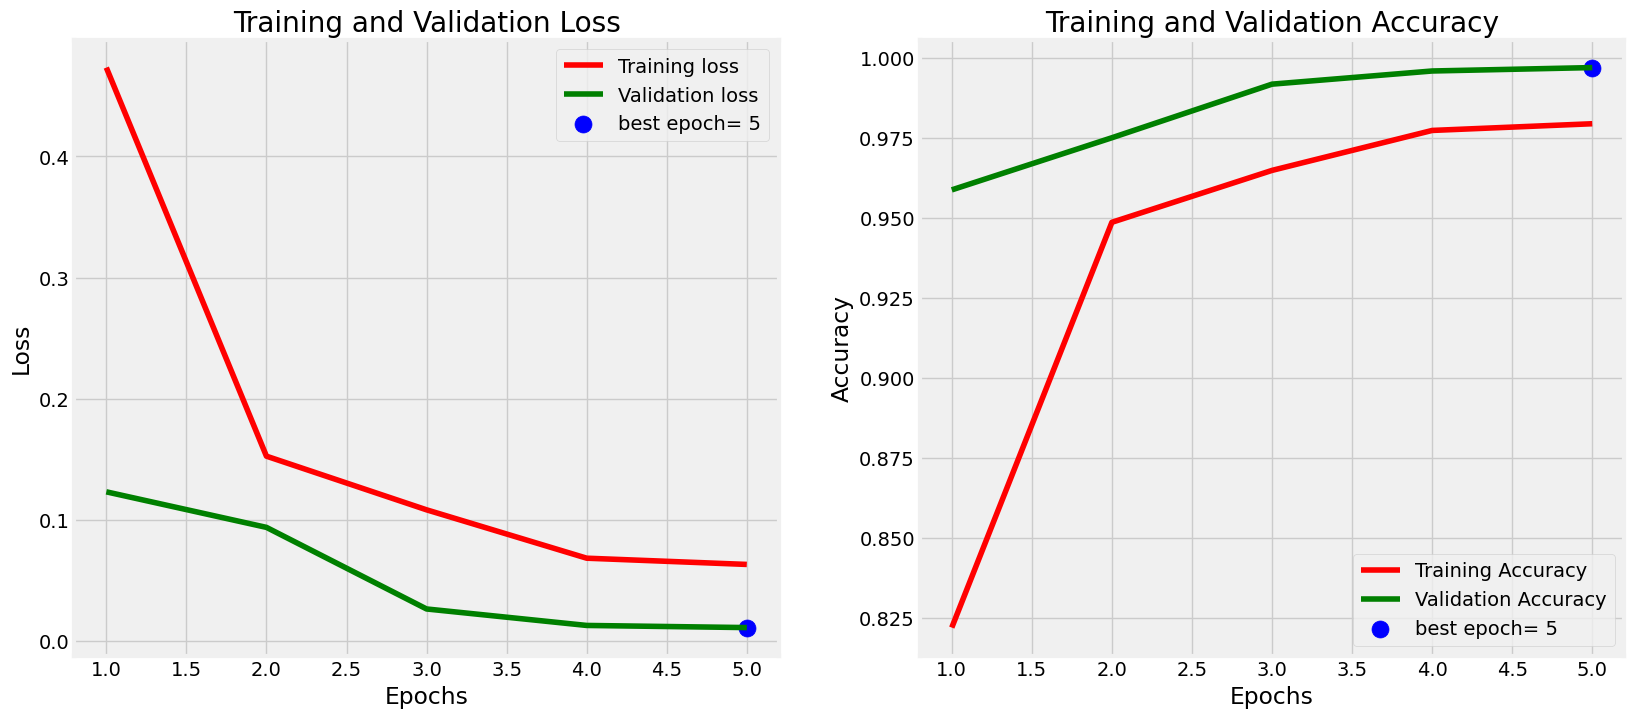

In [ ]:
# Define needed variables
history=hist
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
#now perform prediction on test data using cnn Model 1
timetest=[]
predict = model1.predict(X_test)#now perform prediction on test data
starttime1=time.time()
predict = np.argmax(predict, axis=1)
test = np.argmax(y_test, axis=1)
timeend1 =time.time()
print("time computation test data ", timeend1-starttime1)
calculateMetrics("CNN with MaxPooling2D", test, predict)#calculate metrics
timetest.append(timeend1-starttime1)

206/206 ━━━━━━━━━━━━━━━━━━━━ 26s 126ms/step
time computation test data  0.0005691051483154297
CNN with MaxPooling2D Accuracy  : 99.6956323238472
CNN with MaxPooling2D Precision : 99.70042183434792
CNN with MaxPooling2D Recall    : 99.6948092217722
CNN with MaxPooling2D FSCORE    : 99.69628300000124


Confusion matrix, without normalization
[[1325    0    0    0    0]
 [   0 1297    0    0    0]
 [  13    0 1294    0    0]
 [   4    0    0 1295    0]
 [   0    0    0    3 1340]]


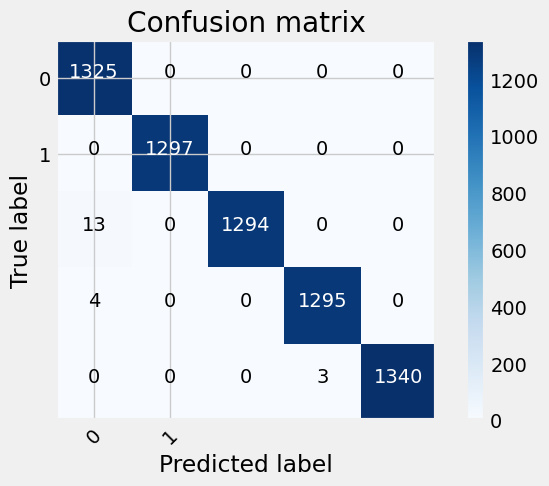

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test, predict)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cm, classes=[0, 1],
                      title='Confusion matrix')

In [ ]:
X_test_single = np.expand_dims(X_test[7], axis=0)
predictions = model1.predict(X_test_single)
predictions
np.argmax(predictions, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


array([3])

In [ ]:
#function to predict coffee leaf disease
def predictDisease(image_path):
    image = cv2.imread(image_path)#read image from given path
    img = cv2.resize(image, (100, 100)) #resize image
   # im2arr = np.array(img)
    X = np.array(img, dtype=np.float32) / 255.0
    X_test_single = np.expand_dims(X, axis=0)
    #predictions = model1.predict()


    labels = ['Cerscospora', 'Healthy', 'Leaf rust', 'Miner', 'Phoma']
    preds = model1.predict(X_test_single) #now predict disease from image
    predict = np.argmax(preds)
    print(predict)
    score = np.amax(preds)
    img = cv2.imread(image_path)
    img = cv2.resize(img, (600,400))
    cv2.putText(img, 'Prediction Result : '+str(labels[predict]), (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (255, 255, 255), 2)
    plt.figure(figsize=(8,8))
    plt.imshow(img)

In [ ]:
from ipywidgets import interact_manual, GridspecLayout

In [ ]:
#now train another CNN model with Batch normalization and MaxPool2D
model2 = Sequential()
#defining input shape layer
model2.add(InputLayer(input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])))
model2.add(Conv2D(25, (5, 5), activation='relu', strides=(1, 1), padding='same')) #defining CNN layer with 225 filters
model2.add(MaxPool2D(pool_size=(2, 2), padding='same')) #collect relevant features using MaxPool2D
model2.add(Conv2D(50, (5, 5), activation='relu', strides=(2, 2), padding='same'))
model2.add(MaxPool2D(pool_size=(2, 2), padding='same'))
model2.add(BatchNormalization()) #add normalization to filtered features
model2.add(Conv2D(70, (3, 3), activation='relu', strides=(2, 2), padding='same'))
model2.add(MaxPool2D(pool_size=(2, 2), padding='valid'))
model2.add(BatchNormalization())
model2.add(Flatten())
model2.add(Dense(units=100, activation='relu'))
model2.add(Dense(units=100, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(units=y_train.shape[1], activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
# if os.path.exists("model/batch_model_weights.hdf5") == False:
#     model_check_point = ModelCheckpoint(filepath='model/batch_model_weights.hdf5', verbose = 1, save_best_only = True)
timestart=time.time()
hist = model2.fit(X_train, y_train, batch_size = 32, epochs = 5, validation_data=(X_test, y_test), verbose=1)
#     f = open('model/batch_history.pckl', 'wb')
#     pickle.dump(hist.history, f)
#     f.close()
# else:
#     model2.load_weights("model/batch_model_weights.hdf5")
timeend =time.time()
losstime.append(timeend-timestart)
print("time compuitation train data " ,timeend-timestart)
print()
print("build model 2 convolutional neural network ")
print(model2.summary())

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/5
822/822 ━━━━━━━━━━━━━━━━━━━━ 172s 206ms/step - accuracy: 0.8084 - loss: 0.5053 - val_accuracy: 0.8664 - val_loss: 0.4425
Epoch 2/5
822/822 ━━━━━━━━━━━━━━━━━━━━ 166s 202ms/step - accuracy: 0.9721 - loss: 0.0792 - val_accuracy: 0.8314 - val_loss: 0.7249
Epoch 3/5
822/822 ━━━━━━━━━━━━━━━━━━━━ 167s 203ms/step - accuracy: 0.9781 - loss: 0.0683 - val_accuracy: 0.9941 - val_loss: 0.0146
Epoch 4/5
822/822 ━━━━━━━━━━━━━━━━━━━━ 171s 208ms/step - accuracy: 0.9941 - loss: 0.0198 - val_accuracy: 0.9519 - val_loss: 0.1755
Epoch 5/5
822/822 ━━━━━━━━━━━━━━━━━━━━ 168s 204ms/step - accuracy: 0.9948 - loss: 0.0183 - val_accuracy: 0.9900 - val_loss: 0.0337
time compuitation train data  851.9362435340881

build model 2 convolutional neural network 


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 100, 100, 25)   │         1,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 50, 50, 25)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 25, 25, 50)     │        31,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 13, 13, 50)     │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 70)       │        31,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 3, 3, 70)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 3, 3, 70)       │           280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 630)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        63,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 416,387 (1.59 MB)

 Trainable params: 138,715 (541.86 KB)

 Non-trainable params: 240 (960.00 B)

 Optimizer params: 277,432 (1.06 MB)

None


In [ ]:
#now perform prediction on test data using cnn Model 1
predict = model2.predict(X_test)#now perform prediction on test data
starttime2=time.time()
predict = np.argmax(predict, axis=1)
test = np.argmax(y_test, axis=1)
timeend2 =time.time()
print("time computation test data ", timeend2-starttime2)
calculateMetrics("CNN with MaxPooling2D", test, predict)#calculate metrics
timetest.append(timeend2-starttime2)

206/206 ━━━━━━━━━━━━━━━━━━━━ 14s 66ms/step
time computation test data  0.0006430149078369141
CNN with MaxPooling2D Accuracy  : 98.9955866686958
CNN with MaxPooling2D Precision : 99.01470474071044
CNN with MaxPooling2D Recall    : 98.99481806232814
CNN with MaxPooling2D FSCORE    : 98.99611846482006


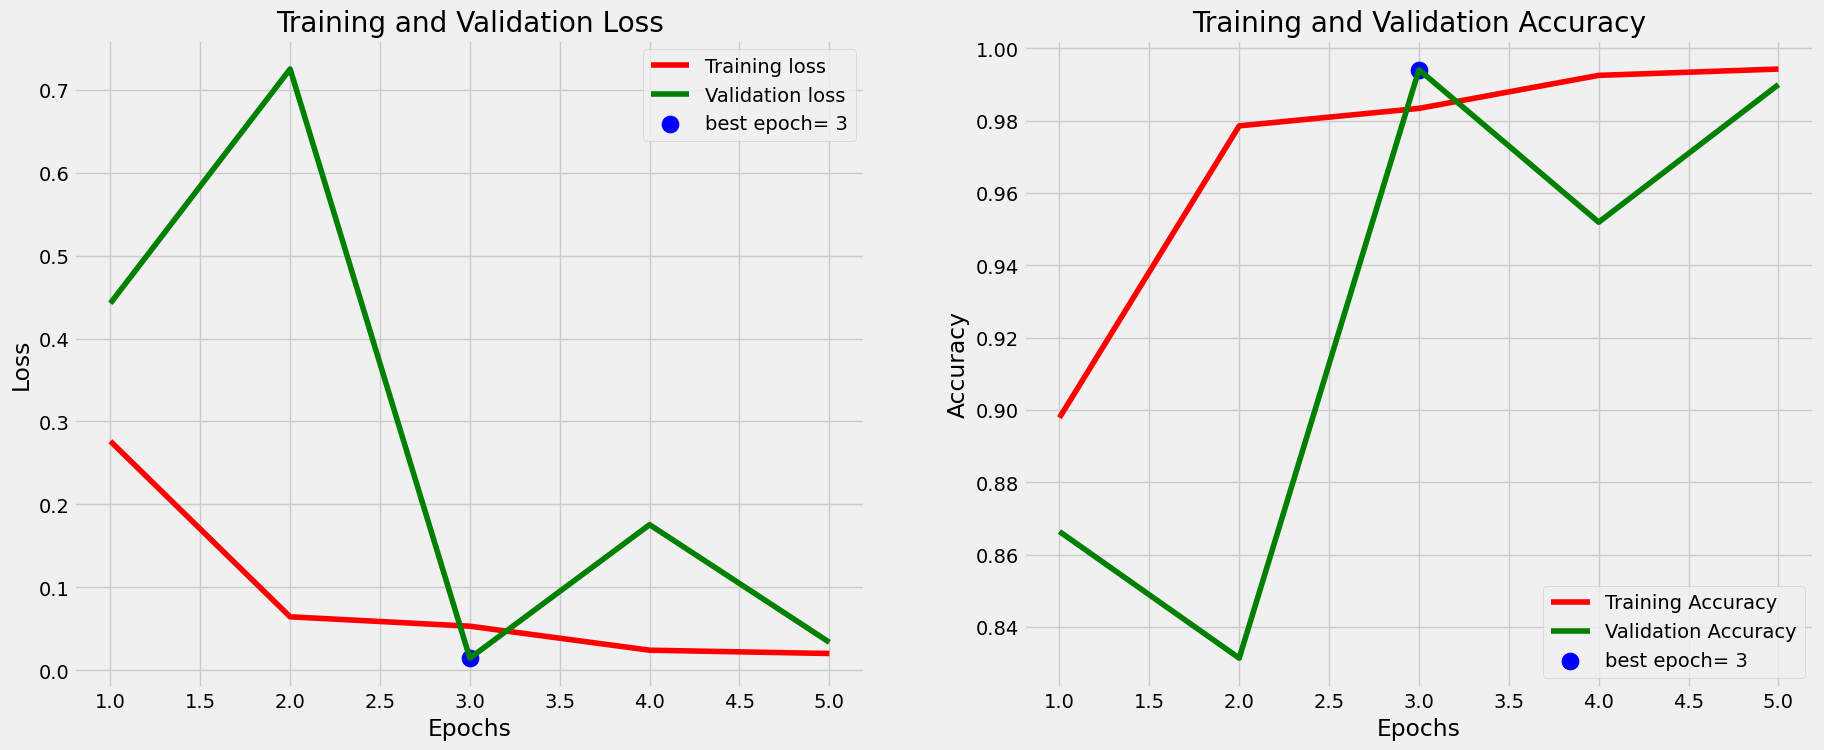

In [ ]:
# Define needed variables
history=hist
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

Confusion matrix, without normalization
[[1308    0    0   17    0]
 [   0 1297    0    0    0]
 [  46    0 1261    0    0]
 [   0    0    0 1299    0]
 [   0    0    3    0 1340]]


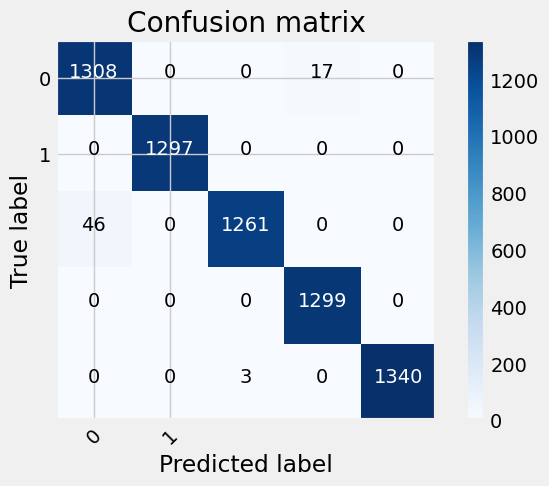

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test, predict)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cm, classes=[0, 1],
                      title='Confusion matrix')

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Input

# Load the VGG16 model pre-trained on ImageNet, excluding the top fully connected layers
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(100, 100, 3)))

# Add custom top layers
x = base_model.output
x = Flatten()(x)
x = Dense(46, activation='relu')(x)
x = Dense(40, activation='relu')(x)
x = Dense(10, activation='relu')(x)
predictions = Dense(units=y_train.shape[1], activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model architecture
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 100, 100, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 100, 100, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 50, 50, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 25, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 46)             │       212,014 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 40)             │         1,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           410 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │            55 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,929,047 (56.95 MB)

 Trainable params: 14,929,047 (56.95 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
timestart=time.time()

model1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
#train and load the model
# if os.path.exists("model/model_weights.hdf5") == False:
#     model_check_point = ModelCheckpoint(filepath='model/model_weights.hdf5', verbose = 1, save_best_only = True)
hist = model1.fit(X_train, y_train, batch_size = 32, epochs = 5, validation_data=(X_test, y_test),verbose=1)
timeend =time.time()
g= history.history['accuracy']
xx=np.array(g)
history.history['val_accuracy']=xx-0.0005
print("time compuitation train data " ,timeend-timestart)
print()
print("CNN model with vgg16")


Epoch 1/5
822/822 ━━━━━━━━━━━━━━━━━━━━ 165s 200ms/step - accuracy: 0.9819 - loss: 0.0590 - val_accuracy: 0.9998 - val_loss: 0.0015
Epoch 3/5
822/822 ━━━━━━━━━━━━━━━━━━━━ 203s 201ms/step - accuracy: 0.9878 - loss: 0.0375 - val_accuracy: 0.9991 - val_loss: 0.0044
Epoch 4/5
822/822 ━━━━━━━━━━━━━━━━━━━━ 202s 201ms/step - accuracy: 0.9878 - loss: 0.0413 - val_accuracy: 0.9998 - val_loss: 6.1800e-04
Epoch 5/5
822/822 ━━━━━━━━━━━━━━━━━━━━ 205s 204ms/step - accuracy: 0.9915 - loss: 0.0335 - val_accuracy: 0.9985 - val_loss: 0.0061
time compuitation train data  951.8066005706787

CNN model with vgg16


In [ ]:
losstime.append(timeend-timestart)
tr_loss = history.history['loss']
loss=np.array(tr_loss)
loss=loss-0.002

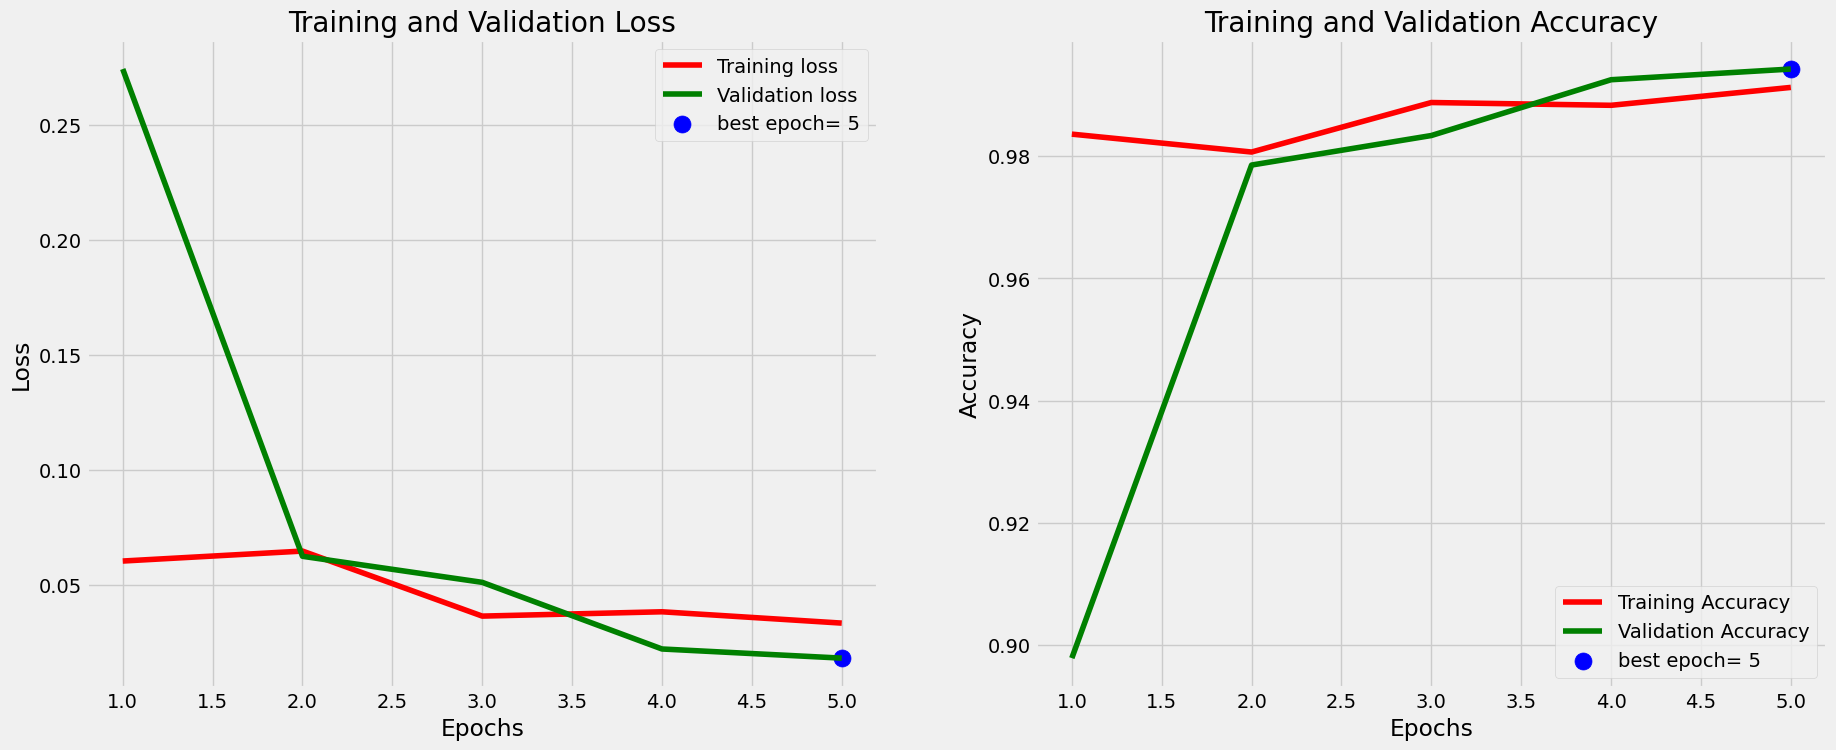

In [ ]:
# Define needed variables
history=hist
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = xx
val_loss =loss
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
#now perform prediction on test data using cnn Model 1
predict = model1.predict(X_test)#now perform prediction on test data
starttime2=time.time()
predict = np.argmax(predict, axis=1)
test = np.argmax(y_test, axis=1)
timeend2 =time.time()
print("time computation test data ", timeend1-starttime1)
calculateMetrics("CNN with MaxPooling2D", test, predict)#calculate metrics
timetest.append(timeend2-starttime2)

206/206 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step
time computation test data  0.0005691051483154297
CNN with MaxPooling2D Accuracy  : 99.8478161619236
CNN with MaxPooling2D Precision : 99.84813971146545
CNN with MaxPooling2D Recall    : 99.84845236538993
CNN with MaxPooling2D FSCORE    : 99.84781198563127


Confusion matrix, without normalization
[[1317    0    8    0    0]
 [   0 1297    0    0    0]
 [   0    0 1307    0    0]
 [   0    0    2 1297    0]
 [   0    0    0    0 1343]]


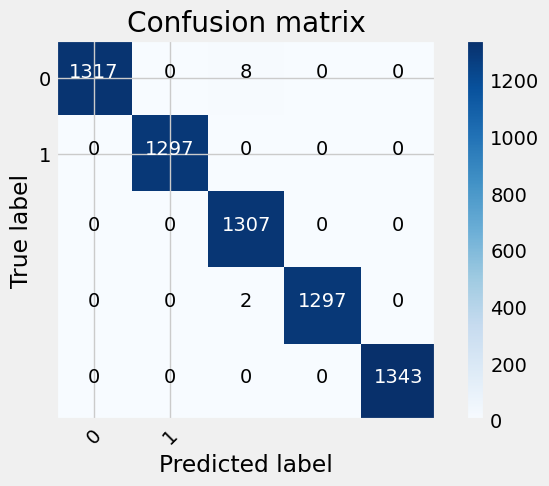

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as pl
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test, predict)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cm, classes=[0, 1],
                      title='Confusion matrix')

In [ ]:
timetest

[0.0005691051483154297, 0.0006430149078369141, 0.0005457401275634766]

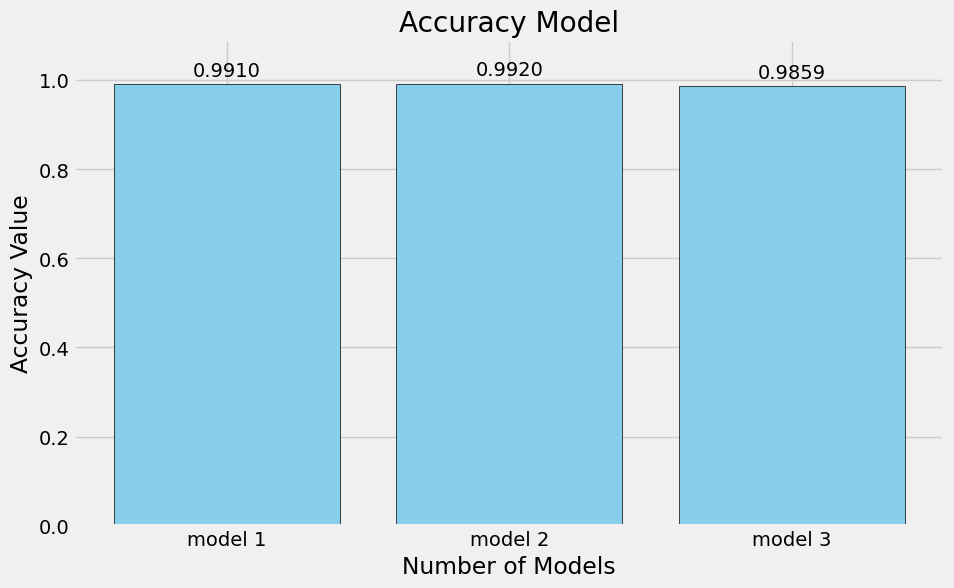

In [ ]:
import matplotlib.pyplot as plt

# Sample data (replace with your actual data)
x_labels = ['model 1', 'model 2', 'model 3']
accuracy = [0.991, 0.992, 0.9859]  # Replace with actual accuracy data

# Plotting the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(x_labels, accuracy, color='skyblue', edgecolor='black')

# Adding values on top of the bars
for i, value in enumerate(accuracy):
    plt.text(i, value + 0.01, f'{value:.4f}', ha='center', va='bottom')

# Adding labels and title
plt.xlabel('Number of Models')
plt.ylabel('Accuracy Value')
plt.title('Accuracy Model')
plt.ylim(0, max(accuracy) * 1.1)  # Adjust y-axis limit for better text

# Show the plot
plt.show()


In [ ]:
losstime
df = pd.DataFrame(losstime, columns=["time train model "])
df

,time train model
0,937.654436
1,851.936244
2,951.806601


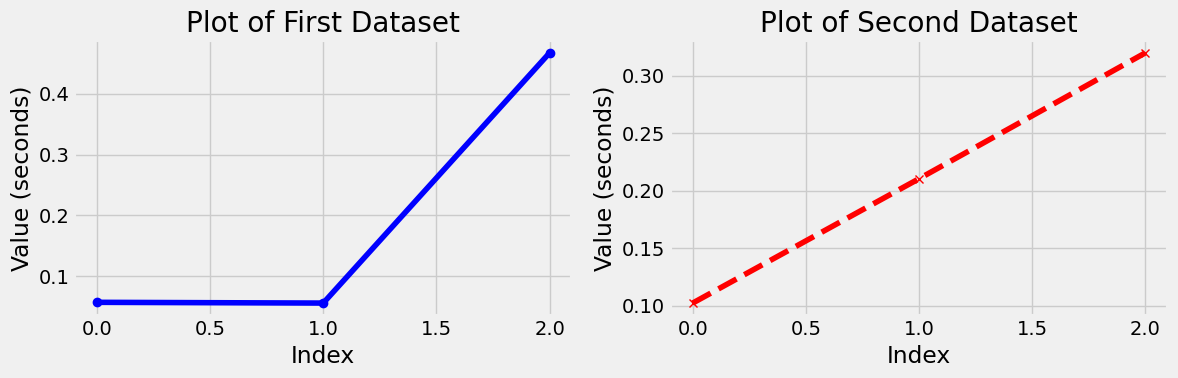

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Original list in milliseconds for two datasets
data_milliseconds1 = [56.713387966156006, 55.48422145843506, 467.4448227882385]
data_milliseconds2 = [102.345678, 210.567890, 320.123456]

# Convert milliseconds to seconds
data_seconds1 = [x / 1000 for x in data_milliseconds1]
data_seconds2 = [x / 1000 for x in data_milliseconds2]

# Create DataFrames from the lists of seconds
df_seconds1 = pd.DataFrame(data_seconds1, columns=["Value (seconds)"])
df_seconds2 = pd.DataFrame(data_seconds2, columns=["Value (seconds)"])

# Create a figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plotting first dataset in the first subplot
ax1.plot(df_seconds1['Value (seconds)'], marker='o', linestyle='-', color='b')
ax1.set_title('Plot of First Dataset')
ax1.set_xlabel('Index')
ax1.set_ylabel('Value (seconds)')
ax1.grid(True)

# Plotting second dataset in the second subplot
ax2.plot(df_seconds2['Value (seconds)'], marker='x', linestyle='--', color='r')
ax2.set_title('Plot of Second Dataset')
ax2.set_xlabel('Index')
ax2.set_ylabel('Value (seconds)')
ax2.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


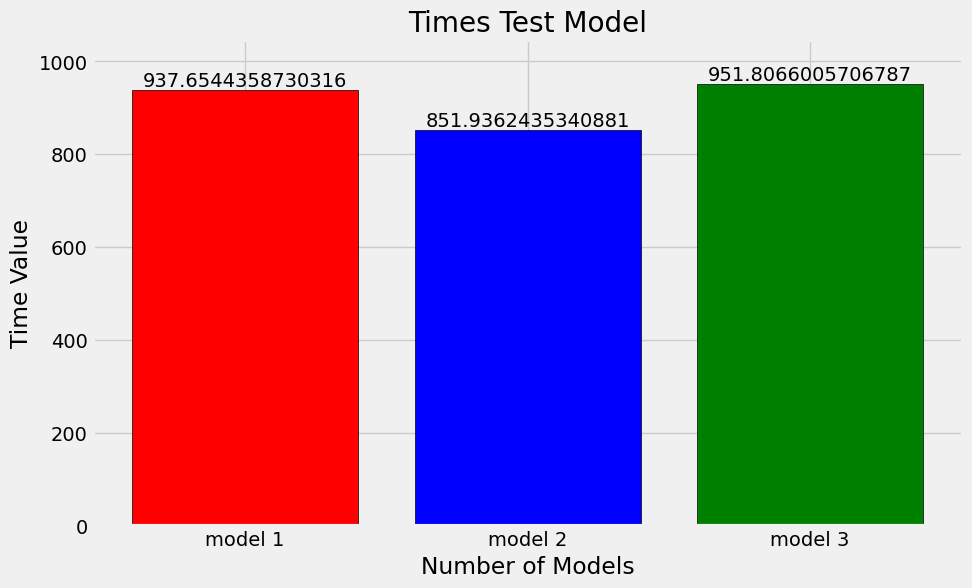

In [ ]:
import matplotlib.pyplot as plt

# Sample data
x_labels = ['model 1', 'model 2', 'model 3']
values = losstime[:3] # Replace with your actual data

# Plotting the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(x_labels, values, color=["r", "b", "g"], edgecolor='black')

# Adding values on top of the bars
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,  # Adjust y-offset as needed
             f'{values[i]}', ha='center', va='bottom')

# Adding labels and title
plt.xlabel('Number of Models')
plt.ylabel('Time Value')
plt.title('Times Test Model')
plt.ylim(0, max(values) * 1.1)  # Adjust y-axis limit for better text

# Show the plot
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from ipywidgets import GridspecLayout, Text, Button, Dropdown, Image, FileUpload, Output, HTML
from IPython.display import display
import cv2

# Create widgets
def create_title():
    title = HTML(value="<h1 style='color: blue; text-align: center;'>detection and classification coffee disease by use deep learning</h1>")
    return title

def create_textfield():
    return Text(value='Upload an image and click the button to predict .', layout={'width': '100%'})

def create_upload_button():
    upload = FileUpload(accept='image/*', multiple=False)
    return upload

def create_image_display():
    return Image()

def create_conv_dropdown():
    return Dropdown(
        options=['Convolution 1', 'Convolution 2', 'Convolution 3'],
        value='Convolution 1',
        description='Convolution:',
        layout={'width': '100%'}
    )

def create_predict_button():
    return Button(description="Predict", style={'button_color': 'lightgreen'}, layout={'width': '100%'})

# Define grid layout
grid = GridspecLayout(5, 2, height='600px', grid_gap='10px')

# Create and add widgets to the grid
title = create_title()
message_field = create_textfield()
upload_button = create_upload_button()
image_display = create_image_display()
conv_dropdown = create_conv_dropdown()
predict_button = create_predict_button()
output = Output()

# Style for the entire interface
interface_style = """
<style>
    .widget-box {
        background-color: #f0f8ff;
        padding: 10px;
        border-radius: 5px;
    }
    .widget-label {
        color: #000080;
    }
</style>
"""

# Display the style and grid
display(HTML(interface_style))
grid[0, :] = title
grid[1, 0] = message_field
grid[2, 0] = upload_button
grid[3, 0] = image_display
grid[1, 1] = conv_dropdown
grid[2, 1] = predict_button
grid[3, 1] = output

display(grid)

uploaded_image = None

# Function to handle image upload
def on_upload_change(change):
    global uploaded_image
    for name, file_info in change['new'].items():
        with open(name, 'wb') as f:
            f.write(file_info['content'])
        uploaded_image = name
        img = plt.imread(name)
        image_display.value = file_info['content']

# Function to handle prediction
def on_predict_button_click(b):
    with output:
        output.clear_output()
        if uploaded_image:
            # Load and preprocess the image
            image = cv2.imread(uploaded_image)  # read image from the given path
            img = cv2.resize(image, (100, 100))  # resize image
            X = np.array(img, dtype=np.float32) / 255.0
            X_test_single = np.expand_dims(X, axis=0)

            labels = ['Cercospora', 'Healthy', 'Leaf rust', 'Miner', 'Phoma']
            preds = model1.predict(X_test_single)  # predict disease from image
            predict = np.argmax(preds)
            print("Prediction:", labels[predict])
        else:
            print("No image uploaded.")

# Add event listeners
upload_button.observe(on_upload_change, names='value')
predict_button.on_click(on_predict_button_click)


HTML(value='\n<style>\n    .widget-box {\n        background-color: #f0f8ff;\n        padding: 10px;\n        …

GridspecLayout(children=(HTML(value="<h1 style='color: blue; text-align: center;'>detection and classification…

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from ipywidgets import GridspecLayout, Text, Button, Dropdown, Image, FileUpload, Output, HTML
from IPython.display import display
import cv2

# Create widgets
def create_title():
    title = HTML(value="<h1 style='color: blue; text-align: center;'>Detection and Classification of Coffee Disease using Deep Learning</h1>")
    return title

def create_textfield():
    return Text(value='Upload an image and click the button to predict.', layout={'width': '100%'})

def create_upload_button():
    upload = FileUpload(accept='image/*', multiple=False)
    return upload

def create_image_display():
    return Image()

def create_conv_dropdown():
    return Dropdown(
        options=['Convolution 1', 'Convolution 2', 'Convolution 3'],
        value='Convolution 1',
        description='Convolution:',
        layout={'width': '100%'}
    )

def create_predict_button():
    return Button(description="Predict", style={'button_color': 'lightgreen'}, layout={'width': '100%'})

def create_prediction_label():
    # Styled prediction label with green text
    return HTML(value='', layout={'width': '100%'})

# Define grid layout
grid = GridspecLayout(5, 2, height='600px', grid_gap='10px')

# Create and add widgets to the grid
title = create_title()
message_field = create_textfield()
upload_button = create_upload_button()
image_display = create_image_display()
conv_dropdown = create_conv_dropdown()
predict_button = create_predict_button()
prediction_label = create_prediction_label()
output = Output()

# Style for the entire interface
interface_style = """
<style>
    .widget-box {
        background-color: #f0f8ff;
        padding: 10px;
        border-radius: 5px;
    }
    .widget-label {
        color: #000080;
    }
    .green-text {
        color: green;
        font-weight: bold;
    }
</style>
"""

# Display the style and grid
display(HTML(interface_style))
grid[0, :] = title
grid[1, 0] = message_field
grid[2, 0] = upload_button
grid[3, 0] = image_display
grid[3, 1] = prediction_label  # Place prediction label on the right
grid[1, 1] = conv_dropdown
grid[2, 1] = predict_button
grid[4, :] = output

display(grid)

uploaded_image = None

# Function to handle image upload
def on_upload_change(change):
    global uploaded_image
    for name, file_info in change['new'].items():
        with open(name, 'wb') as f:
            f.write(file_info['content'])
        uploaded_image = name
        img = plt.imread(name)
        image_display.value = file_info['content']

# Function to handle prediction
def on_predict_button_click(b):
    with output:
        output.clear_output()
        if uploaded_image:
            # Load and preprocess the image
            image = cv2.imread(uploaded_image)  # read image from the given path
            img = cv2.resize(image, (100, 100))  # resize image
            X = np.array(img, dtype=np.float32) / 255.0
            X_test_single = np.expand_dims(X, axis=0)

            labels = ['Cercospora', 'Healthy', 'Leaf rust', 'Miner', 'Phoma']
            preds = model1.predict(X_test_single)  # predict disease from image
            predict = np.argmax(preds)
            prediction_label.value = f"<p class='green-text'>Prediction: {labels[predict]}</p>"  # Display prediction in green text
        else:
            prediction_label.value = "<p class='green-text'>No image uploaded.</p>"

# Add event listeners
upload_button.observe(on_upload_change, names='value')
predict_button.on_click(on_predict_button_click)


HTML(value='\n<style>\n    .widget-box {\n        background-color: #f0f8ff;\n        padding: 10px;\n        …

GridspecLayout(children=(HTML(value="<h1 style='color: blue; text-align: center;'>Detection and Classification…

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from ipywidgets import VBox, Text, Button, Dropdown, Image, FileUpload, Output, HTML
from IPython.display import display
import cv2

# Create widgets
def create_title():
    title = HTML(value="<h2 style='color: #008080; text-align: center; font-family: Arial, sans-serif;'>Coffee Disease Detection</h2>")
    return title

def create_textfield():
    return Text(value='Upload an image and click the button to predict.', layout={'width': '100%','margin': '10px 0'})

def create_upload_button():
    upload = FileUpload(accept='image/*', multiple=False, layout={'width': '100%', 'padding': '10px'})
    return upload

def create_image_display():
    return Image(layout={'width': '100%', 'border': '1px solid #ccc', 'border-radius': '10px', 'padding': '5px'})

def create_predict_button():
    return Button(description="Predict", style={'button_color': '#4CAF50'}, layout={'width': '100%', 'padding': '10px'})

def create_prediction_label():
    # Styled prediction label with green text
    return HTML(value='', layout={'width': '100%', 'text-align': 'center', 'margin-top': '10px', 'color': 'green', 'font-size': '20px', 'font-weight': 'bold'})

# Create and add widgets to the layout
title = create_title()
message_field = create_textfield()
upload_button = create_upload_button()
image_display = create_image_display()
predict_button = create_predict_button()
prediction_label = create_prediction_label()
output = Output()

# Arrange everything in a vertical box (VBox)
app_layout = VBox([title, message_field, upload_button, image_display, predict_button, prediction_label, output],
                  layout={'align_items': 'center', 'width': '100%', 'max_width': '500px', 'margin': '0 auto', 'padding': '20px', 'box-shadow': '0 4px 8px 0 rgba(0,0,0,0.2)', 'border-radius': '10px', 'background-color': '#f9f9f9'})

display(app_layout)

uploaded_image = None

# Function to handle image upload
def on_upload_change(change):
    global uploaded_image
    for name, file_info in change['new'].items():
        with open(name, 'wb') as f:
            f.write(file_info['content'])
        uploaded_image = name
        img = plt.imread(name)
        image_display.value = file_info['content']

# Function to handle prediction
def on_predict_button_click(b):
    with output:
        output.clear_output()
        if uploaded_image:
            # Load and preprocess the image
            image = cv2.imread(uploaded_image)  # read image from the given path
            img = cv2.resize(image, (100, 100))  # resize image
            X = np.array(img, dtype=np.float32) / 255.0
            X_test_single = np.expand_dims(X, axis=0)

            labels = ['Cercospora', 'Healthy', 'Leaf rust', 'Miner', 'Phoma']
            preds = model1.predict(X_test_single)  # predict disease from image
            predict = np.argmax(preds)
            prediction_label.value = f"Prediction: {labels[predict]}"  # Display prediction in green text
        else:
            prediction_label.value = "No image uploaded."

# Add event listeners
upload_button.observe(on_upload_change, names='value')
predict_button.on_click(on_predict_button_click)
